In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
training_df = pd.read_csv('data/training_set.csv')
training_metadata_df = pd.read_csv('data/training_set_metadata.csv')

In [3]:
training_metadata_df.head(5)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [4]:
objs = np.unique(training_df.object_id)
passbands = [0, 1, 2, 3, 4, 5]
targets = np.unique(training_metadata_df.target)

# Normalize and interpolate time series

In [5]:
#training_df_new = pd.DataFrame({'object_id' : np.array([], dtype=int), 'flux' : []})
X = []
y = []
for obj in tqdm(objs):
    data = training_df[training_df.object_id == obj]
    #mean_mjd = np.mean(data.mjd)
    #std_mjd = np.std(data.mjd)
    min_mjd = np.min(data.mjd)
    max_mjd = np.max(data.mjd)
    #mean_flux = np.mean(data.flux)
    #std_flux = np.std(data.flux)
    min_flux = np.min(data.flux)
    max_flux = np.max(data.flux)
    flux_all = []
    for passband in passbands:
        #data = training_df[training_df.object_id == obj][training_df.passband == passband]
        data = training_df.loc[(training_df.object_id == obj) & (training_df.passband == passband)]
        norm_mjd = (data.mjd - min_mjd)/(max_mjd - min_mjd)
        norm_flux = (data.flux - min_flux)/(max_flux - min_flux)
        mjd_interp = np.linspace(np.min(norm_mjd), np.max(norm_mjd), 1000)
        interp = interp1d(norm_mjd, norm_flux, kind='linear')
        flux_interp = interp(mjd_interp)
        flux_all += [flux_interp]
    X += [flux_all]
    y += [1.*(targets == int(training_metadata_df.loc[training_metadata_df.object_id == obj].target))]
    #df = pd.DataFrame(data={'object_id' : np.tile([obj], 6*len(mjd_interp)), 'flux' : flux_all})
    #training_df_new = training_df_new.append(df, ignore_index=True)

100%|██████████| 7848/7848 [06:07<00:00, 21.34it/s]


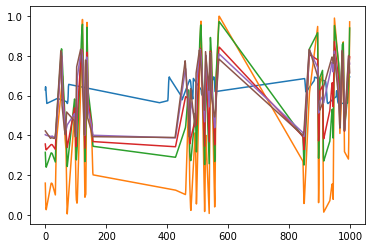

In [6]:
for passband in passbands:
    plt.plot(np.arange(len(X[0][passband])), X[0][passband])
plt.show()

# Deep Learning

In [122]:
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [113]:
N = []
for i in np.arange(len(targets)):
    N += [len(training_metadata_df.loc[training_metadata_df.target == targets[i]])]
w = N/np.sum(N)
print(N)
print(w)

[151, 495, 924, 1193, 183, 30, 484, 102, 981, 208, 370, 2313, 239, 175]
[0.01924057 0.06307339 0.117737   0.15201325 0.02331804 0.00382263
 0.06167176 0.01299694 0.125      0.02650357 0.04714577 0.29472477
 0.03045362 0.02229867]


In [114]:
def LogLoss(y_true, y_pred):
    y_clip = tf.clip_by_value(y_pred, 1e-15, 1-1e-15)
    loss = -(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(y_clip), axis=0)/w))
    return loss

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, stratify=y)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
num_classes = len(targets)

In [116]:
activation = 'relu'
dense_model = Sequential()
dense_model.add(Reshape((6000,), input_shape=(6,1000)))
dense_model.add(Dense(512, activation=activation))
dense_model.add(BatchNormalization())
dense_model.add(Dense(256, activation=activation))
dense_model.add(BatchNormalization())
dense_model.add(Dense(128, activation=activation))
dense_model.add(BatchNormalization())
dense_model.add(Dense(num_classes, activation='softmax'))
print(dense_model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 6000)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               3072512   
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
_________________________________________________________________
dense_59 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_44 (Batc (None, 256)               1024      
_________________________________________________________________
dense_60 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_45 (Batc (None, 128)             

In [117]:
dense_model.compile(loss=LogLoss,
                    #loss=keras.losses.mean_squared_error,
                    optimizer='adam',
                    metrics=['accuracy'])

In [118]:
print(X_train.shape)
print(y_train.shape)

(6278, 6, 1000)
(6278, 14)


In [119]:
epochs = 100
batch_size = 32
dense_model.reset_states()
history = dense_model.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_test, y_test))

Train on 6278 samples, validate on 1570 samples
Epoch 1/100
6278/6278 [==============================] - 16s 3ms/step - loss: 2.3772 - accuracy: 0.2093 - val_loss: 2.2678 - val_accuracy: 0.2217
Epoch 2/100
6278/6278 [==============================] - 27s 4ms/step - loss: 2.0549 - accuracy: 0.2568 - val_loss: 2.1038 - val_accuracy: 0.2019
Epoch 3/100
6278/6278 [==============================] - 19s 3ms/step - loss: 1.9070 - accuracy: 0.2818 - val_loss: 2.1655 - val_accuracy: 0.2408
Epoch 4/100
6278/6278 [==============================] - 18s 3ms/step - loss: 1.8378 - accuracy: 0.3085 - val_loss: 2.1821 - val_accuracy: 0.2121
Epoch 5/100
6278/6278 [==============================] - 15s 2ms/step - loss: 1.7358 - accuracy: 0.3210 - val_loss: 2.2682 - val_accuracy: 0.2707
Epoch 6/100
6278/6278 [==============================] - 13s 2ms/step - loss: 1.6665 - accuracy: 0.3305 - val_loss: 1.9581 - val_accuracy: 0.3669
Epoch 7/100
6278/6278 [==============================] - 19s 3ms/step - loss

6278/6278 [==============================] - 12s 2ms/step - loss: 0.7910 - accuracy: 0.5430 - val_loss: 2.3762 - val_accuracy: 0.3382
Epoch 57/100
6278/6278 [==============================] - 12s 2ms/step - loss: 0.7632 - accuracy: 0.5530 - val_loss: 2.4539 - val_accuracy: 0.3841
Epoch 58/100
6278/6278 [==============================] - 13s 2ms/step - loss: 0.7439 - accuracy: 0.5610 - val_loss: 2.3925 - val_accuracy: 0.4096
Epoch 59/100
6278/6278 [==============================] - 12s 2ms/step - loss: 0.7472 - accuracy: 0.5534 - val_loss: 2.3231 - val_accuracy: 0.3949
Epoch 60/100
6278/6278 [==============================] - 12s 2ms/step - loss: 0.7766 - accuracy: 0.5505 - val_loss: 2.4240 - val_accuracy: 0.4178
Epoch 61/100
6278/6278 [==============================] - 13s 2ms/step - loss: 0.8976 - accuracy: 0.5209 - val_loss: 2.5412 - val_accuracy: 0.3790
Epoch 62/100
6278/6278 [==============================] - 15s 2ms/step - loss: 0.8320 - accuracy: 0.5287 - val_loss: 2.5890 - val_a

In [130]:
activation = 'relu'
CNN_model = Sequential()
CNN_model.add(Reshape((6, 1000, 1), input_shape=(6,1000)))
CNN_model.add(Conv2D(64, kernel_size=3, activation=activation))
CNN_model.add(Conv2D(32, kernel_size=3, activation=activation))
CNN_model.add(Flatten())
CNN_model.add(Dense(num_classes, activation='softmax'))
print(CNN_model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 6, 1000, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 998, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 996, 32)        18464     
_________________________________________________________________
flatten_5 (Flatten)          (None, 63744)             0         
_________________________________________________________________
dense_64 (Dense)             (None, 14)                892430    
Total params: 911,534
Trainable params: 911,534
Non-trainable params: 0
_________________________________________________________________
None


In [131]:
CNN_model.compile(loss=LogLoss,
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 128
history = CNN_model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))

Train on 6278 samples, validate on 1570 samples
Epoch 1/100
6278/6278 [==============================] - 74s 12ms/step - loss: 2.3008 - accuracy: 0.1846 - val_loss: 2.1160 - val_accuracy: 0.2166
Epoch 2/100
6278/6278 [==============================] - 70s 11ms/step - loss: 1.9702 - accuracy: 0.2732 - val_loss: 1.9456 - val_accuracy: 0.2624
Epoch 3/100
6278/6278 [==============================] - 72s 12ms/step - loss: 1.7061 - accuracy: 0.3350 - val_loss: 1.8165 - val_accuracy: 0.3299
Epoch 4/100
6278/6278 [==============================] - 69s 11ms/step - loss: 1.5341 - accuracy: 0.3660 - val_loss: 1.8120 - val_accuracy: 0.2866
Epoch 5/100
6278/6278 [==============================] - 72s 12ms/step - loss: 1.4464 - accuracy: 0.3721 - val_loss: 1.8940 - val_accuracy: 0.3433
Epoch 6/100
6278/6278 [==============================] - 105s 17ms/step - loss: 1.3051 - accuracy: 0.4298 - val_loss: 1.9397 - val_accuracy: 0.4000
Epoch 7/100
6278/6278 [==============================] - 82s 13ms/ste